In [2]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
dftrain = pd.read_csv("ccdatatrain.csv")
dftest = pd.read_csv("ccdatatest.csv")

In [4]:
y_train = dftrain.pop('ovdose')
y_eval = dftest.pop('ovdose')

In [5]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['mx_hydrocodone','mx_oxycodone','mx_tramadol','mx_codeine','mx_propoxyphene','mx_meperidine','mx_hydromorphone','mx_morphine','mx_fentanyl','mx_tapentadol','mx_partial','mx_semi','mx_methadone','mx_buprenorphine']
NUMERIC_COLUMNS = ['sum_methadone','sum_buprenorphine','sum_benzo','sum_smr','sum_hypno','sum_pregaba','hydrocodone_ge2','oxycodone_ge2','tramadol_ge2','codeine_ge2','propoxyphene_ge2','meperidine_ge2','hydromorphone_ge2','morphine_ge2','fentanyl_ge2','tapentadol_ge2','partial_ge2','semi_ge2','pdmp_previousday','total_dayssup','totalla_dayssup','totalsa_dayssup','x_opioid_benzo','x_opioid_smr','x_benzo_smr','x_opioid_benzo_smr','refill','refill_la','refill_sa','sum_ovlap_days_all','sum_ovlap_days_sa','sum_ovlap_days_la','unique_ingredients','unique_ingredients_gt2','count_scripts','count_scripts_ge4','std_30_scripts','tots_prescribers','tots_dispensaries']

In [6]:
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                                vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))

In [7]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dftest, y_eval, shuffle=False, n_epochs=1)

In [8]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
linear_result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(linear_result))

accuracy                  0.994154
accuracy_baseline         0.994154
auc                       0.578679
auc_precision_recall      0.010603
average_loss              0.036146
label/mean                0.005846
loss                      0.021998
precision                 0.000000
prediction/mean           0.008873
recall                    0.000000
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/z1/bqspjgxj1rg30p44yzmtv__h0000gp/T/tmpiweufbvk/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


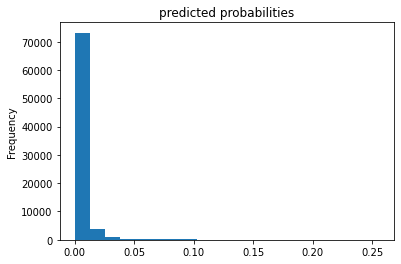

In [9]:
leanear_pred_dicts = list(linear_est.predict(eval_input_fn))
leaner_probs = pd.Series([pred['probabilities'][1] for pred in leanear_pred_dicts])

leaner_probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

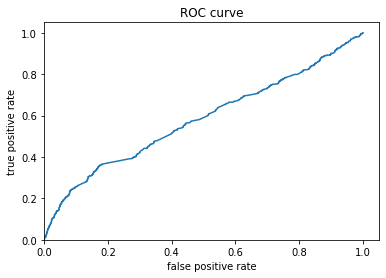

In [10]:
# print aoc curve for linear regression model
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, leaner_probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [11]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)
# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(results))

accuracy                  0.994116
accuracy_baseline         0.994154
auc                       0.679923
auc_precision_recall      0.018619
average_loss              0.034381
label/mean                0.005846
loss                      0.019870
precision                 0.000000
prediction/mean           0.005961
recall                    0.000000
global_step             100.000000
dtype: float64


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/z1/bqspjgxj1rg30p44yzmtv__h0000gp/T/tmp4cnorh5_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

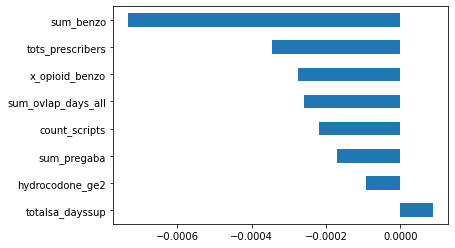

In [12]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = example[sorted_ix].plot(kind='barh')

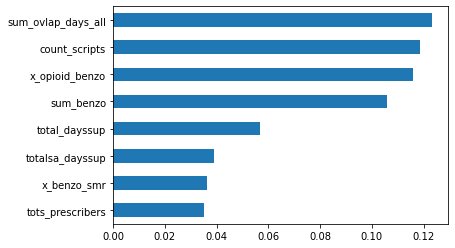

In [13]:
# Get importances
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/z1/bqspjgxj1rg30p44yzmtv__h0000gp/T/tmp4cnorh5_/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


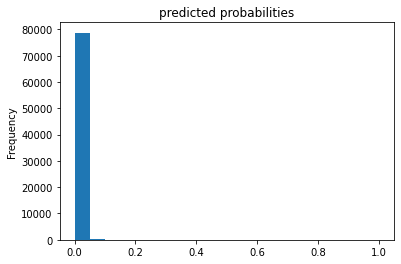

In [14]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

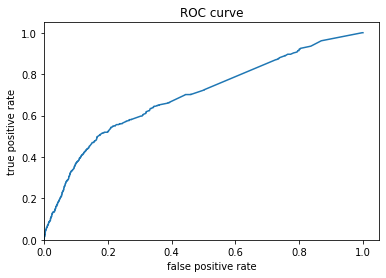

In [15]:
# print aoc curve for linear regression model
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()